## Using the Burket Profile to model the Dark Matter Halo
As we have seen within the previous part of this project, the uniform density sphere model of dark matter does not fit the data well. So we are going to instead use the Burkert profile to model the dark matter halo. It has two additional parameters, $\rho_0$ and $r_0$, which are the central density(how much dark matter is at the center) and the scale radius(how spread out the dark matter is from the core) of the dark matter halo. The Burkert profile is given by the following equation:
  
$v(r) = \sqrt{\frac{GM_{\text{in}}(r)}{r}}$
  
$M_{\text{in}}(r) = \int_0^r 4\pi \rho(r') r'^2 \, dr'$
  
$\rho(r) = \begin{cases} 
\rho_0+\frac{\rho_{1}}{(1 + \frac{r}{r_1}) (1 + (\frac{r}{r_1})^2)} , & \text{if } r < r_0 \\
\frac{\rho_{1}}{(1 + \frac{r}{r_1}) (1 + (\frac{r}{r_1})^2)}, & \text{otherwise}
\end{cases}$



In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee

#read in and clean the data 
new_data=pd.read_csv('UGC06787_rot.csv')
new_new_new_data=new_data[1:]
new_data['R_Dist(meters)']=new_data['R_dist(kpc)'].astype(float)*3.086e19
new_data['V_rot(m/s)']=new_data['Vobs(km/s)'].astype(float)*1e3
new_data['V_rot_err(m/s)']=new_data['errV(km/s)'].astype(float)*1e3
R_dist=new_data['R_Dist(meters)']
V_rot=new_data['V_rot(m/s)']
V_rot_err=new_data['V_rot_err(m/s)']

Defining the Burkert profile

In [3]:
def p(r,r0,p0,p1,dark_r1):
    #Dark mass
    part1 = 1+(r/dark_r1)
    part2 = 1+(r/dark_r1)**2
    dark_mass = p1 / (part1*part2)

    if r<r0:
        return p0+dark_mass
    else:
        return dark_mass

#new parameters have been introduced to this model to account for the burkert profile
def M_in(r,p0,r0,p1,dark_r1):
    lst=[]
    for r1 in r:
        #Light mass
        intergrand = lambda r_prime: 4*np.pi*p(r_prime,r0,p0,p1,dark_r1)*(r_prime**2)
        light_mass, _ = quad(intergrand,1e-6,r1)

        lst.append(light_mass)
    
    return np.array(lst)

#Does not change with the new parameters except passing them into the M_in function
def velocity_profile(r,p0,r0,p1,dark_r1):
    G = 6.6743e-11
    M = M_in(r,p0,r0,p1,dark_r1)
    return np.sqrt(G*M/r)

Our walker function works relatively the same as the previous sections of this projects. The only difference is that we are now passing in two additional arguments, $p_1$ and $r_1$. We set the prior function to make sure these values are never negative.

In [4]:
def ln_prior(params):
    p0,r0,p1,dark_r1 = params
    if p0>0 and r0>0 and p1>0 and dark_r1>0:
        return 0
    return -np.inf

#Finds how well the model fits the data
def ln_likelihood(params,r,V_obs,V_err):
    p0,r0,p1,dark_r1 = params
    v_model_pred = velocity_profile(r,p0,r0,p1,dark_r1)
    return -0.5*np.sum((V_obs-v_model_pred)**2/V_err**2)

#Finds how likely the model is
def ln_pdf(params,r, V_obs, V_err):
    p=ln_prior(params)
    if p==-np.inf:
        return -np.inf
    return p + ln_likelihood(params,r,V_obs,V_err) 

Now that we have everything nessacary we run the walkers and collect the results. This is also similar to the last two parts but we now have 4 parameters to fit($p_0,r_0,p_1,r_1$). Due to the high number of parameters to crawl we need to start our walkers close to the area it will burn into. To do this we find a better starting position and start them randomly scattered around there.

In [5]:
# Generate linearly independent initial positions for the walkers
n_walkers = 10
ndim = 4
nsteps = 2000
kpc=3.086e19
mean=[1e-18,1e18,1e-18,1e20]
cov=[[1e-40,0,0,0],[0,3.086e18,0,0],[0,0,1e-40,0],[0,0,0,3.086e20]]
initial_position = np.random.multivariate_normal(mean, cov,n_walkers)

sampler = emcee.EnsembleSampler(n_walkers, ndim, ln_pdf, args=[new_data['R_Dist(meters)'], new_data['V_rot(m/s)'], new_data['V_rot_err(m/s)']])
sampler.run_mcmc(initial_position, nsteps, progress=True)
samples = sampler.get_chain()

 16%|█▋        | 326/2000 [01:57<13:23,  2.08it/s]/var/folders/b5/jqnd0ktj68gcq3l3764mxkz80000gn/T/ipykernel_26976/1849689633.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  light_mass, _ = quad(intergrand,1e-6,r1)
100%|██████████| 2000/2000 [15:02<00:00,  2.22it/s]


Now we plot them to get an idea of how long the burn in period is, and wether they converged or not. After looking at the graph we see they converged and the burn in period is about 750 steps.

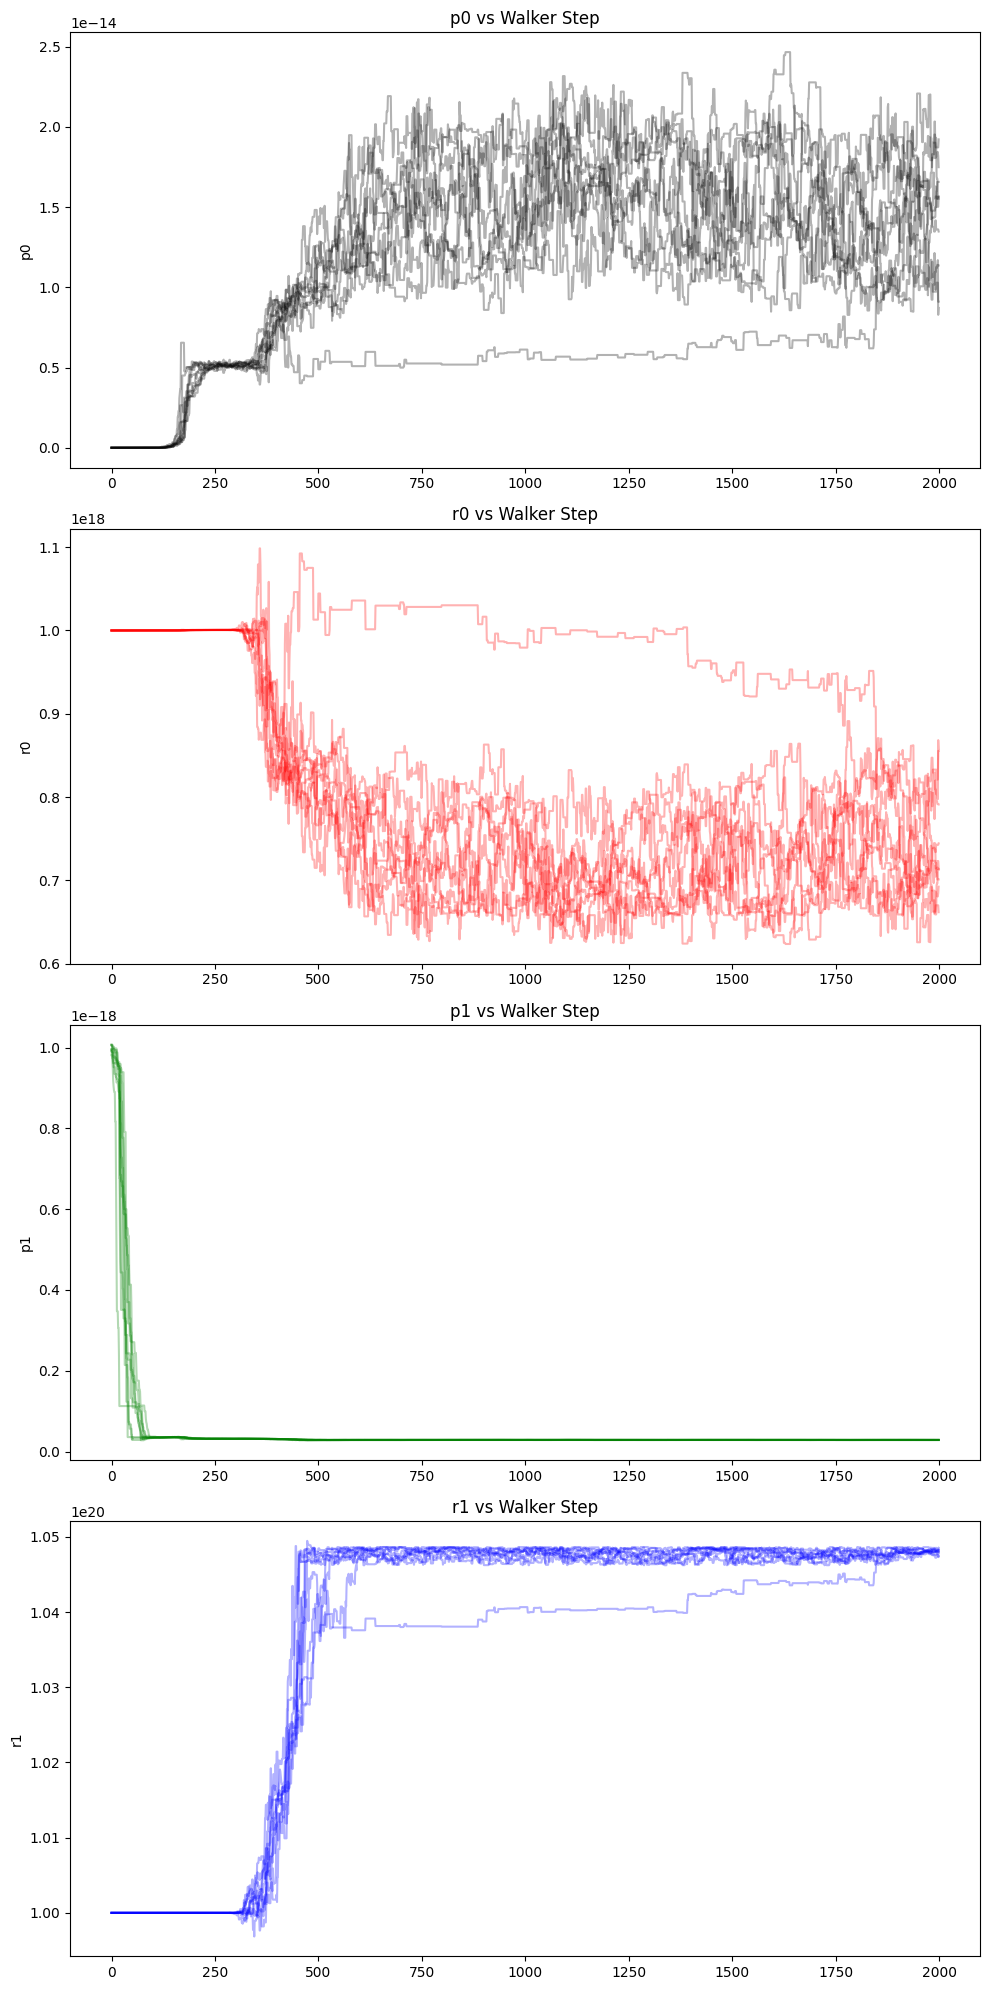

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

axs[0].plot(samples[:, :, 0], 'k', alpha=0.3)
axs[0].set_ylabel('p0')
axs[0].set_title('p0 vs Walker Step')

axs[1].plot(samples[:, :, 1], 'r', alpha=0.3)
axs[1].set_ylabel('r0')
axs[1].set_title('r0 vs Walker Step')

axs[2].plot(samples[:, :, 2], 'g', alpha=0.3)
axs[2].set_ylabel('p1')
axs[2].set_title('p1 vs Walker Step')

axs[3].plot(samples[:, :, 3], 'b', alpha=0.3)
axs[3].set_ylabel('r1')
axs[3].set_title('r1 vs Walker Step')

plt.tight_layout()
plt.show()


We made a corner plot to see where the walkers spent the most time in parameter space. Looking at the graph we can see that the walkers have converged successfully and there is a few exceptable values for the parameters. 

(12500, 4)


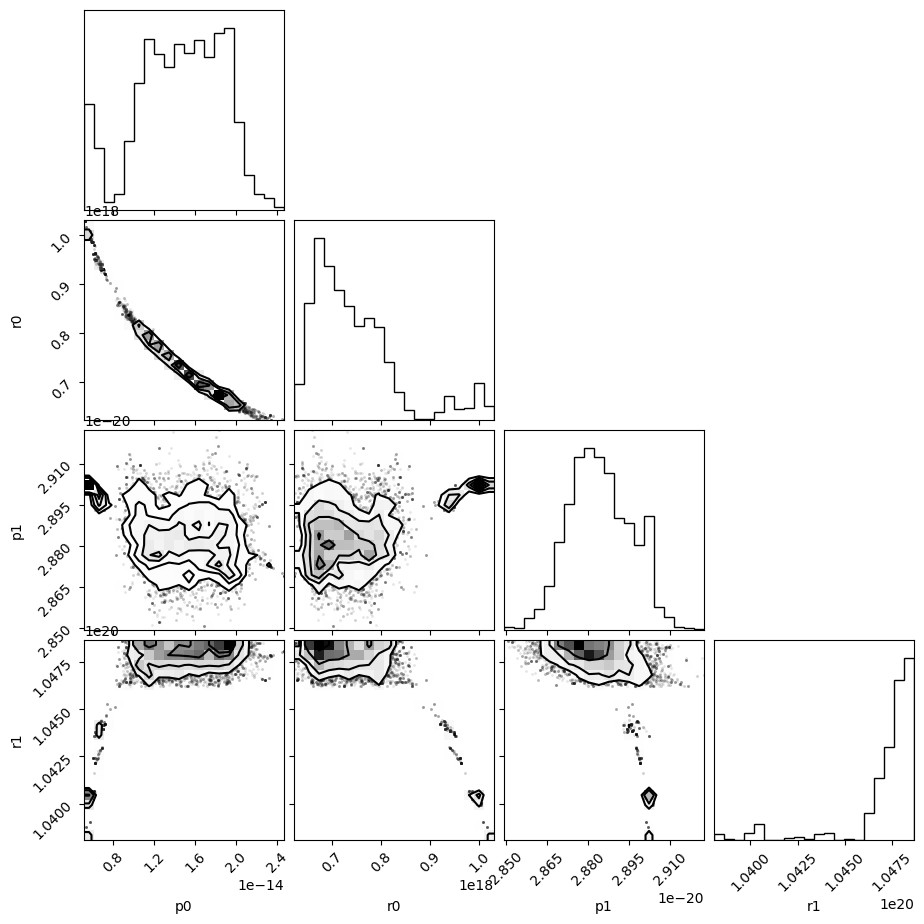

In [7]:
import corner

# Flatten the samples
flat_samples = sampler.get_chain(discard=750, flat=True)
print(flat_samples.shape)

# Plot the corner plot
fig = corner.corner(flat_samples, labels=['p0', 'r0', 'p1', 'r1'])


Now we can use the median $p_0,r_0,p_1,r_1$ values to best model using the Burket profile. We can see that the Burkert profile fits the data much better than the previous uniform density sphere model.

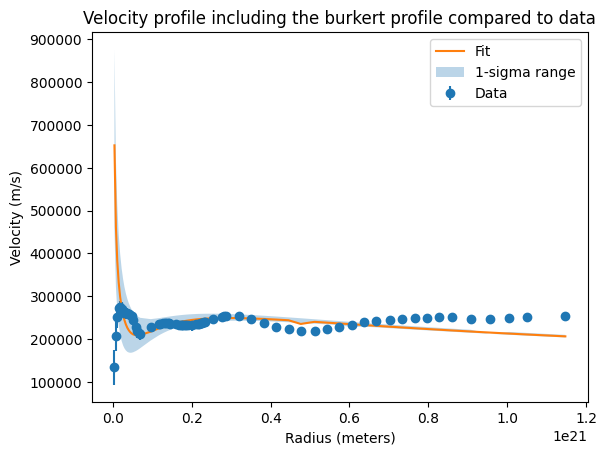

In [8]:

# Get the median and 1-sigma range of the samples
p0_median, r0_median, p1_median, r1_median = np.median(flat_samples, axis=0)
p0_sigma, r0_sigma, p1_sigma, r1_sigma = np.std(flat_samples, axis=0)

# Draw the resulting fit function onto the data
plt.figure()
plt.errorbar(new_data['R_Dist(meters)'], new_data['V_rot(m/s)'], yerr=new_data['V_rot_err(m/s)'], fmt='o', label='Data')
plt.plot(new_data['R_Dist(meters)'], velocity_profile(new_data['R_Dist(meters)'], p0_median, r0_median, p1_median, r1_median), label='Fit')
plt.fill_between(new_data['R_Dist(meters)'], velocity_profile(new_data['R_Dist(meters)'], p0_median-p0_sigma, r0_median-r0_sigma, p1_median-p1_sigma, r1_median-r1_sigma), velocity_profile(new_data['R_Dist(meters)'], p0_median+p0_sigma, r0_median+r0_sigma, p1_median+p1_sigma, r1_median+r1_sigma), alpha=0.3, label='1-sigma range')
plt.xlabel('Radius (meters)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity profile including the burkert profile compared to data')
plt.legend()
plt.show()
